In [103]:
# extract tabular data from xlsx files & data preprocessing

import pandas as pd

file_path = 'IF.xlsx'

full_data = pd.read_excel(file_path, sheet_name='Sheet1')
full_data['date'] = pd.to_datetime(full_data['date'], format='%Y-%m-%d')
full_data = full_data.sort_values(by='date')

print(full_data.head())

   Unnamed: 0     code       date         high         open          low  \
0           0  IF.STAR 2014-12-31  3629.344971  3520.114990  3513.116943   
1           1  IF.STAR 2015-01-05  3808.710449  3645.882080  3624.120117   
2           2  IF.STAR 2015-01-06  3751.840088  3704.093262  3656.368408   
3           3  IF.STAR 2015-01-07  3728.693848  3705.989502  3662.371094   
4           4  IF.STAR 2015-01-08  3731.784180  3725.778076  3605.295410   

         close      vol      oi  
0  3626.701660  1526454  215437  
1  3711.989746  1500643  237221  
2  3701.137695  1737699  236054  
3  3711.765869  1475006  231591  
4  3610.805664  1807466  229779  


In [108]:
# calculating factors

import numpy as np

def feature_eng(df):

    # MA
    df['MA5'] = df['close'].rolling(window=5).mean()
    df['MA10'] = df['close'].rolling(window=10).mean()
    df['MA30'] = df['close'].rolling(window=30).mean()

    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # MACD
    df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Volatility
    df['Volatility5'] = df['close'].pct_change().rolling(window=5).std() * np.sqrt(5)

    # more factors can be added there
    # ....

    # gen (-1, 0, 1) for (-1%, -1% ~ 1%, 1%) close price change
    df['label'] = 0
    df.loc[df['close'].pct_change() < -0.005, 'label'] = -1
    df.loc[df['close'].pct_change() > 0.005, 'label'] = 1

    # drop NaN
    df.dropna(inplace=True)
    




feature_eng(full_data)

train_data = full_data[full_data['date'] <= '2020-12-31']
val_data = full_data[(full_data['date'] > '2020-12-31') & (full_data['date'] <= '2022-12-31')]
test_data = full_data[full_data['date'] > '2022-12-31']
test_data.loc[test_data.index, 'label'] = 0

print(f"Training set size: {train_data.shape[0]}")
print(f"Validation set size: {val_data.shape[0]}")
print(f"Test set size: {test_data.shape[0]}")

print(train_data.head())


Training set size: 1347
Validation set size: 485
Test set size: 288
     Unnamed: 0     code       date         high         open          low  \
116         116  IF.STAR 2015-06-25  4909.437988  4878.345703  4571.535156   
117         117  IF.STAR 2015-06-26  4618.621582  4583.796387  4213.058105   
118         118  IF.STAR 2015-06-29  4406.177246  4346.048340  3818.423096   
119         119  IF.STAR 2015-06-30  4445.208008  4064.663818  3975.569092   
120         120  IF.STAR 2015-07-01  4481.141602  4388.150391  4009.469971   

           close      vol      oi          MA5         MA10         MA30  \
116  4587.782715  2209492  162018  4749.515527  4979.379199  5020.639876   
117  4213.058105  2355785  153014  4604.097168  4870.892920  5005.506885   
118  4009.195312  3185557  139128  4481.444043  4735.681641  4986.955680   
119  4381.071777  2512956  146514  4410.341406  4653.915674  4981.991878   
120  4056.343506  2435322  134903  4249.490283  4552.653735  4958.175789   

      

Text(2023-01-03 00:00:00, 6000, 'Test')

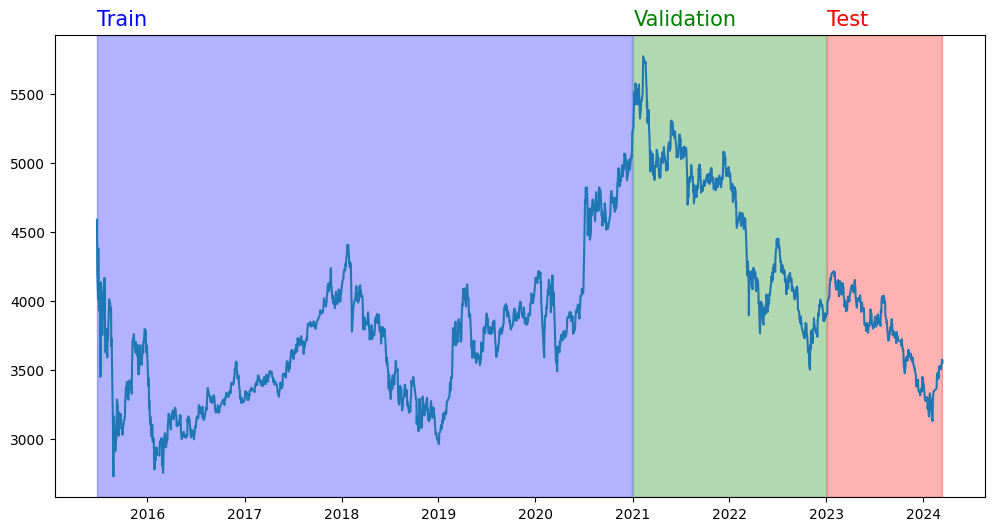

In [109]:
# debug
import matplotlib.pyplot as plt

# plot full_data['close']
plt.figure(figsize=(12, 6))
plt.plot(full_data['date'], full_data['close'])

# use different background colors to show train_data, val_data, test_data
plt.axvspan(train_data['date'].iloc[0], train_data['date'].iloc[-1], color='blue', alpha=0.3)
plt.text(train_data['date'].iloc[0], 6000, 'Train', color='blue', fontsize=15)

plt.axvspan(val_data['date'].iloc[0], val_data['date'].iloc[-1], color='green', alpha=0.3)
plt.text(val_data['date'].iloc[0], 6000, 'Validation', color='green', fontsize=15)

plt.axvspan(test_data['date'].iloc[0], test_data['date'].iloc[-1], color='red', alpha=0.3)
plt.text(test_data['date'].iloc[0], 6000, 'Test', color='red', fontsize=15)


Text(0, 215, '0')

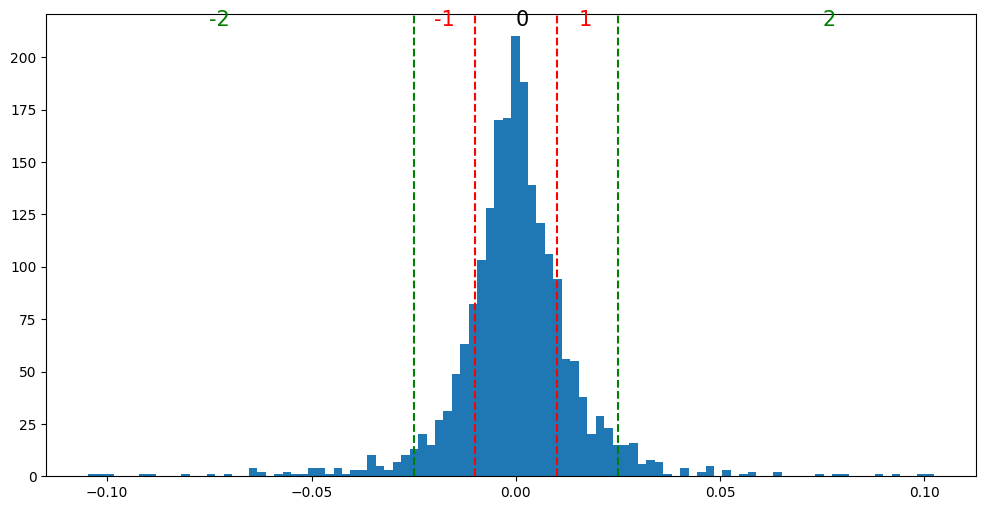

In [110]:
# plot percentage change
# plt.figure(figsize=(12, 6))
# plt.plot(full_data['date'], full_data['close'].pct_change())

# show histogram of percentage change
plt.figure(figsize=(12, 6))
plt.hist(full_data['close'].pct_change(), bins=100)
# add a vertical line at x=+-0.01, +-0.025

plt.axvline(x=0.025, color='g', linestyle='--')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=-0.01, color='r', linestyle='--')
plt.axvline(x=-0.025, color='g', linestyle='--')

# text [2, 1, 0, -1, -2] at the corresponding position
plt.text(0.075, 215, '2', color='g', fontsize=15)
plt.text(0.0155, 215, '1', color='r', fontsize=15)
plt.text(-0.02, 215, '-1', color='r', fontsize=15)
plt.text(-0.075, 215, '-2', color='g', fontsize=15)
plt.text(0, 215, '0', color='black', fontsize=15)

In [111]:
# use AutoGluon to train a model, predict labels
from autogluon.tabular import TabularPredictor

label = 'label'

predictor = TabularPredictor(label=label)
predictor.fit(train_data, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels\ag-20240422_134707\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels\ag-20240422_134707\"
AutoGluon Version:  0.8.2
Python Version:     3.10.6
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
Disk Space Avail:   1454.87 GB / 2047.44 GB (71.1%)
Train Data Rows:    1347
Train Data Columns: 18
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [-1, 1, 0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Cla

In [112]:
# show AutoGluon leaderboard
predictor.leaderboard(val_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L2,0.727835,0.784707,4.624540,1.242855,290.572652,0.153398,0.049041,17.505764,2,True,16
1,WeightedEnsemble_L3,0.727835,0.786934,4.779942,1.410046,292.122554,0.002002,0.001001,0.288354,3,True,26
2,CatBoost_BAG_L2,0.717526,0.772829,4.512442,1.243814,337.239676,0.041299,0.050001,64.172788,2,True,20
3,LightGBM_BAG_L2,0.713402,0.770601,4.579644,1.231431,289.523426,0.108502,0.037617,16.456538,2,True,17
4,XGBoost_BAG_L2,0.713402,0.773571,5.386681,1.257511,294.799187,0.915538,0.063697,21.732300,2,True,23
5,NeuralNetTorch_BAG_L2,0.711340,0.767632,4.658430,1.339499,315.538189,0.187287,0.145685,42.471301,2,True,24
6,RandomForestEntr_BAG_L2,0.698969,0.764662,4.532419,1.302813,273.713583,0.061276,0.108999,0.646695,2,True,19
7,RandomForestGini_BAG_L2,0.696907,0.761693,4.561933,1.301003,273.751559,0.090790,0.107190,0.684672,2,True,18
8,LightGBMLarge_BAG_L2,0.686598,0.764662,4.898774,1.265248,304.883866,0.427631,0.071434,31.816978,2,True,25
9,ExtraTreesEntr_BAG_L2,0.680412,0.754269,4.533753,1.252814,273.643764,0.062610,0.059000,0.576876,2,True,22


In [116]:
# Trade on test dates, calculate the profit

# trade rule : if predictions in last 3 day have more than 2 of 1, buy 1, if more than 2 of -1, sell 1

principal = 5000000 # devide into 5 parts 1 for each trade

def trade(principal, data):
    amount_per_trade = principal / 10
    commission = 150
    slippage = 1
    contract_size = 300 * 0.12 # 12% of margin ratio

    df = data.copy()
    df.loc[:, 'label'] = predictor.predict(df)
    df.loc[:, 'buy_signal'] = df['label'].rolling(5).apply(lambda x: (x == 1).sum() >= 3)
    df.loc[:, 'sell_signal'] = df['label'].rolling(5).apply(lambda x: (x == -1).sum() >= 2)
    
    trades = []
    remaining_principal = principal
    principal_record = []
    positions = 0
    asset_record = []
    position_record = []

    for index, row in df.iterrows():
        contracts_to_trade = int(amount_per_trade / (row['close'] * contract_size))
        
        if row['buy_signal'] and remaining_principal >= amount_per_trade and contracts_to_trade > 0:
            cost = commission + row['close'] * contracts_to_trade * contract_size * (slippage / 100)
            remaining_principal -= contracts_to_trade * row['close'] * contract_size + cost
            positions += contracts_to_trade
            trades.append(('buy', row['close'], contracts_to_trade, index))
        
        elif row['sell_signal'] and positions >= contracts_to_trade and contracts_to_trade > 0:
            proceeds = contracts_to_trade * row['close'] * contract_size
            cost = commission + proceeds * (slippage / 100)
            remaining_principal += proceeds - cost
            positions -= contracts_to_trade
            trades.append(('sell', row['close'], contracts_to_trade, index))
        
        # Update asset and position record
        current_asset_value = remaining_principal + positions * row['close'] * contract_size
        asset_record.append(current_asset_value)
        position_record.append(positions)  

    return trades, remaining_principal, principal_record, positions, asset_record, position_record

trades, remaining_principal, principal_record, positions, asset_record, position_record = trade(principal, test_data)


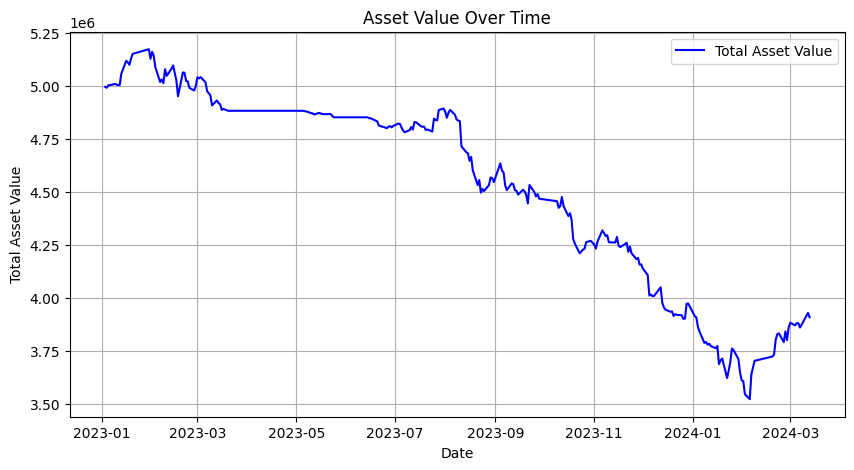

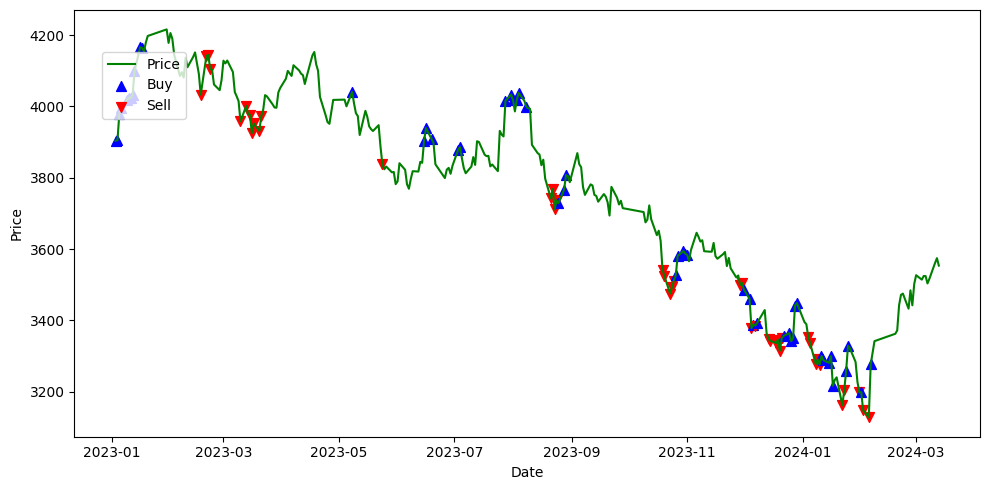

In [117]:
def plots(data, trades, asset_record, position_record):
    plt.figure(figsize=(10, 5))
    plt.plot(data['date'], asset_record, linestyle='-', color='b', label='Total Asset Value')
    plt.title("Asset Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Asset Value")
    plt.grid(True)
    plt.legend()

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(data['date'], data['close'], linestyle='-', color='g', label='Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.tick_params(axis='y')

    # ax2 = ax1.twinx() 
    # ax2.plot(data['date'], position_record, linestyle='-', color='r', label='Positions')
    # ax2.set_ylabel('Positions')
    # ax2.tick_params(axis='y')

    buy_legend_added = False
    sell_legend_added = False
    for trade in trades:
        if trade[0] == 'buy':
            ax1.scatter(data['date'][trade[3]], trade[1], color='blue', s=50, label='Buy' if not buy_legend_added else "", marker='^')
            buy_legend_added = True
        elif trade[0] == 'sell':
            ax1.scatter(data['date'][trade[3]], trade[1], color='red', s=50, label='Sell' if not sell_legend_added else "", marker='v')
            sell_legend_added = True

    fig.tight_layout() 
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    plt.show()

plots(test_data, trades, asset_record, position_record)